In [159]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import urllib.request

from sklearn.linear_model import LinearRegression
import sklearn.metrics

Now plotting with preprocessed US city air pollution GeoDataFrame, unpacking shapely Point geometries into latitude and longitude columns for later use

In [144]:
gdf_us = gpd.read_file('datasets/us-cities-air-pollution.shp')
gdf_us['lng'] = gdf_us.geometry.x
gdf_us['lat'] = gdf_us.geometry.y

Some starting analysis of the dataset

In [140]:
gdf_us.describe()

,AQI Value,CO AQI Val,Ozone AQI,NO2 AQI Va,PM2.5 AQI,lng,lat
count,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000,2868.000000
mean,59.720014,1.456067,27.624128,8.534868,58.028591,-91.940725,37.749531
std,22.826182,2.569132,13.156842,8.007485,23.970113,16.431204,5.627030
min,12.000000,0.000000,0.000000,0.000000,7.000000,-176.477936,0.195418
25%,47.000000,1.000000,19.000000,3.000000,45.000000,-97.913316,33.941164
50%,55.000000,1.000000,27.000000,6.000000,54.000000,-88.005498,39.012439
75%,68.000000,2.000000,35.000000,12.000000,67.000000,-80.222463,41.650562
max,500.000000,133.000000,125.000000,53.000000,500.000000,-65.653167,65.796359


In [141]:
gdf_us.corr()

,AQI Value,CO AQI Val,Ozone AQI,NO2 AQI Va,PM2.5 AQI,lng,lat
AQI Value,1.000000,0.531486,-0.326499,0.587458,0.950210,-0.012285,-0.015207
CO AQI Val,0.531486,1.000000,-0.174362,0.326554,0.516902,-0.009455,-0.009438
Ozone AQI,-0.326499,-0.174362,1.000000,-0.667843,-0.486680,-0.006417,0.009044
NO2 AQI Va,0.587458,0.326554,-0.667843,1.000000,0.620085,-0.004675,-0.003790
PM2.5 AQI,0.950210,0.516902,-0.486680,0.620085,1.000000,-0.011447,-0.007307
lng,-0.012285,-0.009455,-0.006417,-0.004675,-0.011447,1.000000,0.051585
lat,-0.015207,-0.009438,0.009044,-0.003790,-0.007307,0.051585,1.000000


In particular, note that the correlation coefficient between the Air Quality Index Value and the PM2.5 AQI is 0.950210 -a strong correlation. We can further explore the relationships between air quality and the presence of these substances in this air using more visualizations. Begin with downloading shapefiles for US states and counties from census.gov's TIGER

In [44]:
states_filename = "tl_2022_us_state.zip"
states_url = f"https://www2.census.gov/geo/tiger/TIGER2022/STATE/{states_filename}"
states_file = pathlib.Path(states_filename)

counties_filename = "tl_2022_us_county.zip"
counties_url = f"https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/{counties_filename}"
counties_file = pathlib.Path(counties_filename)

for file, url in zip([states_file, counties_file], [states_url, counties_url]):
    if not file.is_file():
        with urllib.request.urlopen(url) as resp, \
            open(file, "wb") as f:
            f.write(resp.read())
gdf_states = gpd.read_file(f"zip://{states_file}")
gdf_counties = gpd.read_file(f"zip://{counties_file}")

Removing some extraneous geometries to focus on mainland America

In [4]:
removeList = ['Commonwealth of the Northern Mariana Islands', 'American Samoa', 'Guam', 'United States Virgin Islands']
for index, row in gdf_states.iterrows():
    temp = row.NAME
    if temp in removeList:
        print("Removed")
        gdf_states = gdf_states.drop(index=index)
gdf_states = gdf_states.reset_index()

Removed
Removed
Removed
Removed


Plotting each city's point geometry on a subplot of all US states, following the OrRd colormap for AQI value.

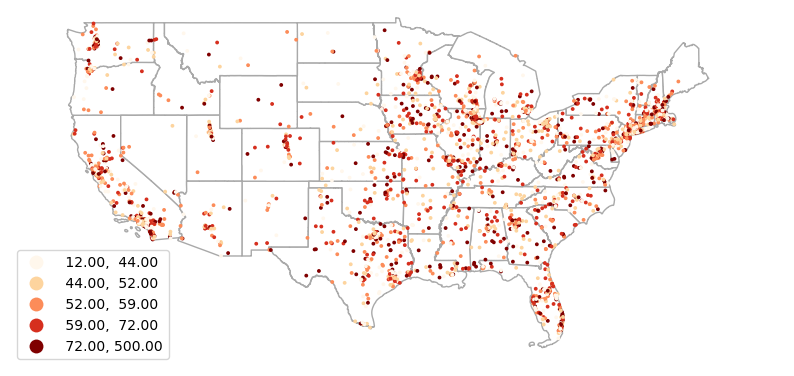

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
gdf_states.plot(ax=ax, color="white", edgecolor="darkgrey")
gdf_us.plot(ax=ax, column='AQI Value', legend=True, cmap='OrRd', marker='o', markersize=3, scheme='quantiles')
ax.set_xlim(-130, -60)
ax.set_ylim(23, 50)
ax.set_axis_off();

Next, a collection of hexbin subplots following the BuGn colormap that, through using latitude and longitude as y and x values respectively, manage to approximate the shape of the United States. We expect for the distribution of color for 'AQI Value' and 'PM2.5 AQI' to appear very similar to each other. 

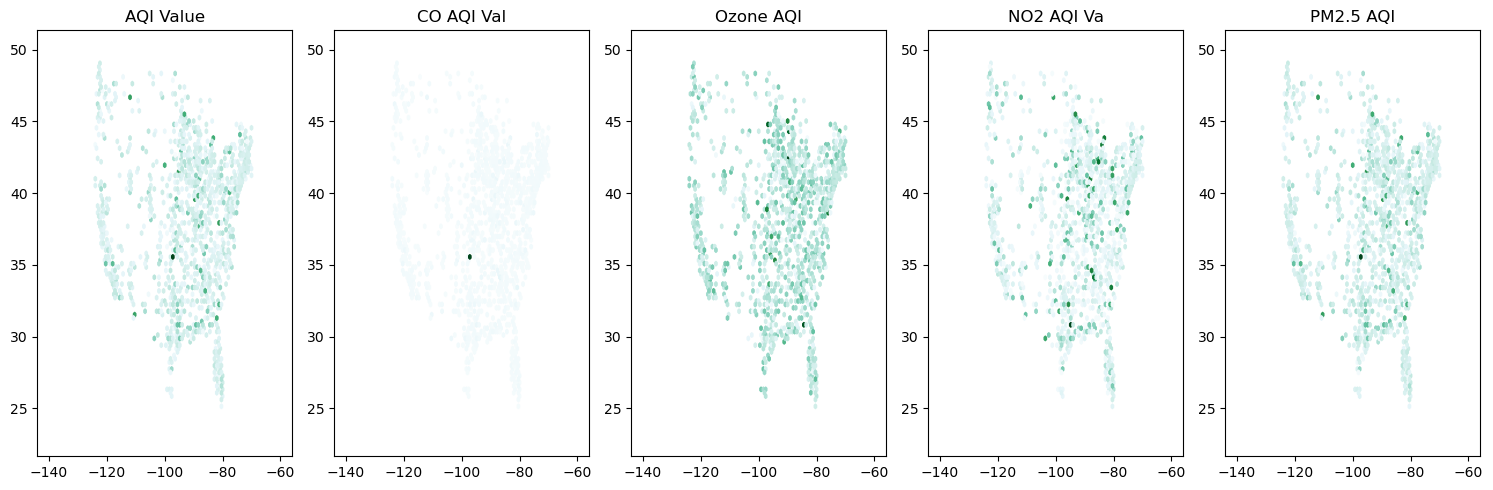

In [142]:
AQI_list = ['AQI Value', 'CO AQI Val', 'Ozone AQI', 'NO2 AQI Va', 'PM2.5 AQI']
fig = plt.figure(figsize=(15,5))
for i in range(len(AQI_list)):
    plt.subplot(1, 5, i+1)
    plt.title(AQI_list[i])
    plt.hexbin(x=gdf_us['lng'], y=gdf_us['lat'], C=gdf_us[AQI_list[i]], gridsize=100, extent=[-140, -60, 23, 50], cmap='BuGn')
plt.tight_layout()
plt.show()

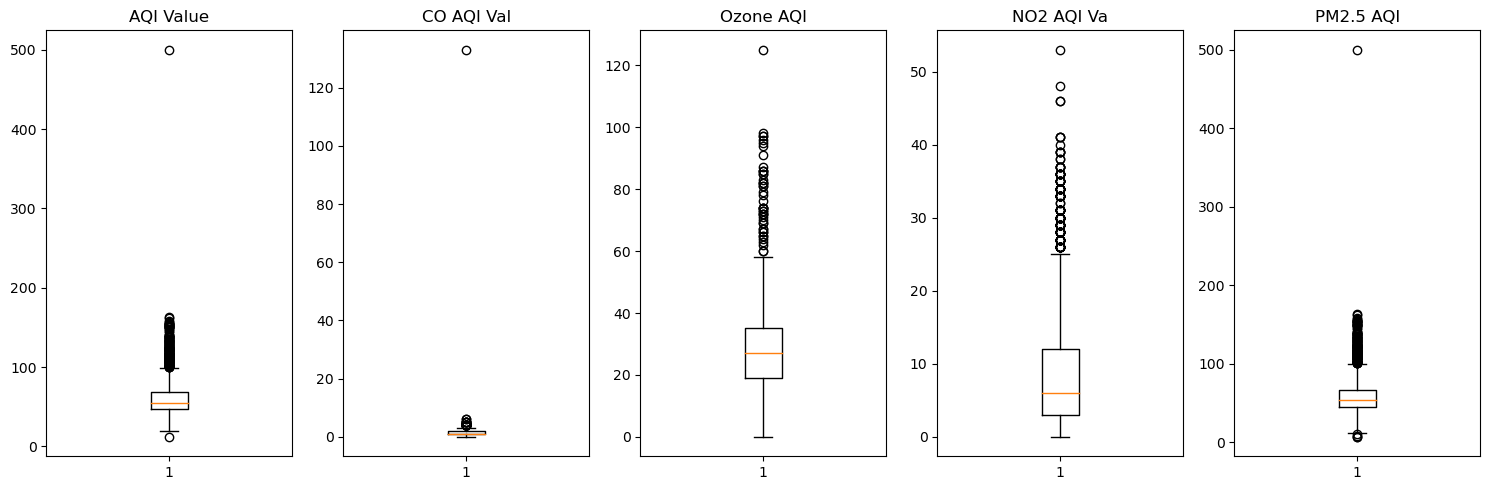

In [139]:
fig = plt.figure(figsize=(15,5))
for i in range(len(AQI_list)):
    plt.subplot(1, 5, i+1)
    plt.title(AQI_list[i])
    plt.boxplot(x=gdf_us[AQI_list[i]])
plt.tight_layout()
plt.show()

Next, to fully explore the relationship between particulates and air quality index, I import the worldwide air pollution dataset.

In [147]:
df = pd.read_csv('datasets/global air pollution dataset.csv')

Running some preliminary analysis

In [149]:
df.describe()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
count,23463.000000,23463.000000,23463.000000,23463.000000,23463.000000
mean,72.010868,1.368367,35.193709,3.063334,68.519755
std,56.055220,1.832064,28.098723,5.254108,54.796443
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,1.000000,21.000000,0.000000,35.000000
50%,55.000000,1.000000,31.000000,1.000000,54.000000
75%,79.000000,1.000000,40.000000,4.000000,79.000000
max,500.000000,133.000000,235.000000,91.000000,500.000000


In [150]:
df.corr()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
AQI Value,1.000000,0.430602,0.405310,0.231758,0.984327
CO AQI Value,0.430602,1.000000,0.145724,0.488092,0.438557
Ozone AQI Value,0.405310,0.145724,1.000000,-0.181818,0.339887
NO2 AQI Value,0.231758,0.488092,-0.181818,1.000000,0.260127
PM2.5 AQI Value,0.984327,0.438557,0.339887,0.260127,1.000000


Experimenting with linear models

In [153]:
model = LinearRegression()
features = ['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']

In [158]:
ind = df[['PM2.5 AQI Value']]
dep = df['AQI Value']
model.fit(ind, dep)
df['Predicted AQI Value'] = model.predict(ind)
df

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,Predicted AQI Value
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate,54.369554
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,44.300170
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate,69.473631
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good,23.154463
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good,9.057326
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23458,India,Gursahaiganj,184,Unhealthy,3,Good,154,Unhealthy,2,Good,184,Unhealthy,188.292364
23459,France,Sceaux,50,Good,1,Good,20,Good,5,Good,50,Good,53.362616
23460,India,Mormugao,50,Good,1,Good,22,Good,1,Good,50,Good,53.362616
23461,United States of America,Westerville,71,Moderate,1,Good,44,Good,2,Good,71,Moderate,74.508323


In [161]:
rmse = np.sqrt(sklearn.metrics.mean_squared_error(df['AQI Value'], df['Predicted AQI Value']))
rmse

9.885420391544011